In [1]:
import urllib
import PIL.Image
import tensorflow_docs.plots

import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
mpl.rcParams['figure.figsize'] = (12, 5)

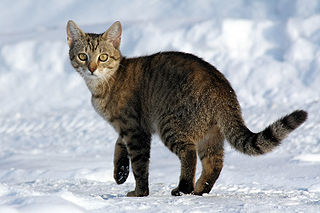

In [4]:
# Example Image

image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [5]:
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels = 3)

In [6]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

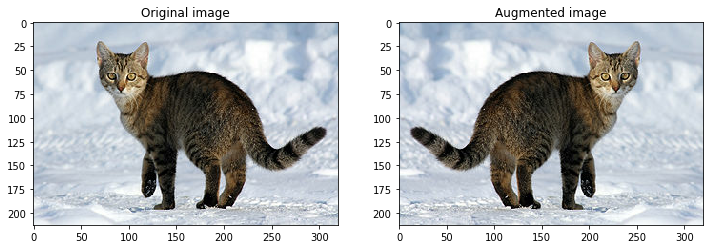

In [7]:
# Flip Image

flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

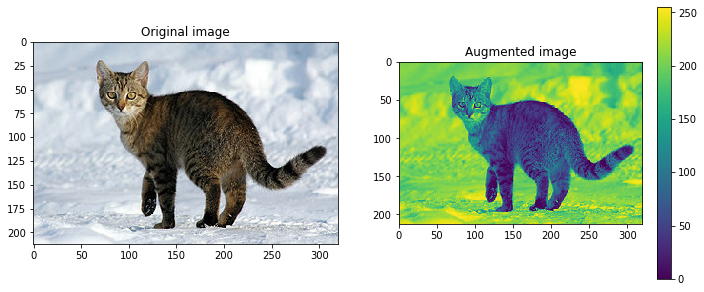

In [8]:
# Grayscale Image

grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

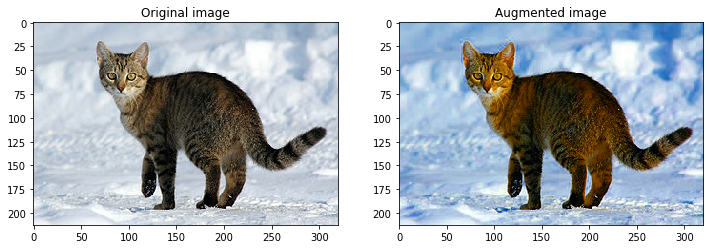

In [9]:
# Saturate the Image

saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

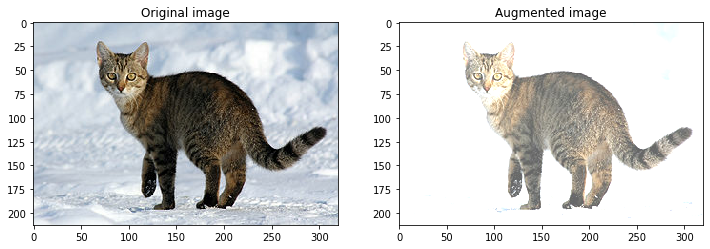

In [10]:
# Change Image Brightness

bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

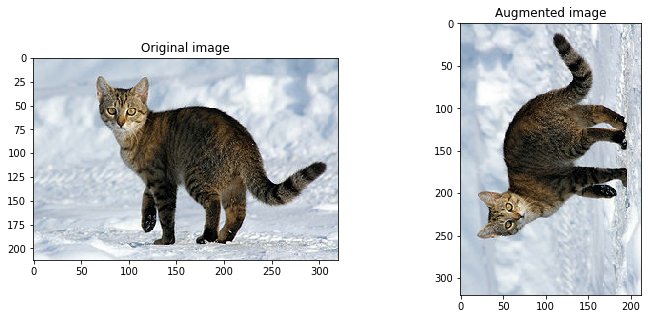

In [11]:
# Rotate Image

rotated = tf.image.rot90(image)
visualize(image, rotated)

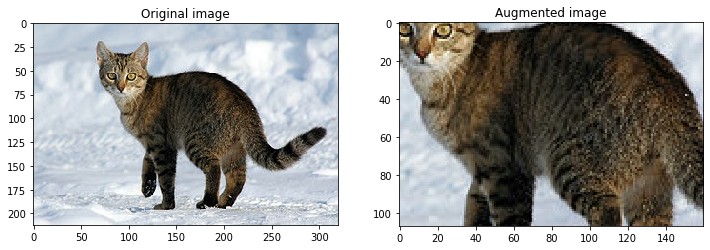

In [12]:
# Center Crop the image

cropped = tf.image.central_crop(image, central_fraction = 0.5)
visualize(image,cropped)

In [13]:
# Dataset Augmentation

dataset, info =  tfds.load('mnist', as_supervised = True, with_info = True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples = info.splits['train'].num_examples

In [14]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size = [28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta = 0.5) # Random brightness

  return image,label

In [15]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [16]:
# Create augmented data

augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls = AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [17]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls = AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [18]:
# validation dataset

validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls = AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [19]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape = (28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy'])
  return model

In [ ]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs = 50, validation_data = validation_batches)

Epoch 1/50
32/32 [==============================] - 1s 44ms/step - loss: 0.7877 - accuracy: 0.7358 - val_loss: 0.2989 - val_accuracy: 0.9148
Epoch 2/50
32/32 [==============================] - 1s 23ms/step - loss: 0.1858 - accuracy: 0.9443 - val_loss: 0.3265 - val_accuracy: 0.9039
Epoch 3/50
32/32 [==============================] - 1s 24ms/step - loss: 0.0808 - accuracy: 0.9751 - val_loss: 0.2859 - val_accuracy: 0.9213
Epoch 4/50
32/32 [==============================] - 1s 24ms/step - loss: 0.0454 - accuracy: 0.9878 - val_loss: 0.3626 - val_accuracy: 0.9172
Epoch 5/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0273 - accuracy: 0.9907 - val_loss: 0.3443 - val_accuracy: 0.9244
Epoch 6/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0363 - accuracy: 0.9907 - val_loss: 0.3477 - val_accuracy: 0.9190
Epoch 7/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0215 - accuracy: 0.9922 - val_loss: 0.2974 - val_accuracy: 0.9306
Epoch 8/50
32